# [spooky-author-identification](https://www.kaggle.com/c/spooky-author-identification)

In [1]:
!pip install torchtext

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
#!kaggle competitions download -c spooky-author-identification

In [4]:
#!unzip spooky-author-identification.zip

In [5]:
#!unzip train.zip
#!unzip test.zip

In [6]:
import pandas as pd

df_train = pd.read_csv('train.csv')

In [7]:
df_train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [8]:
df_train.describe()

,id,text,author
count,19579,19579,19579
unique,19579,19579,3
top,id26305,"This process, however, afforded me no means of...",EAP
freq,1,1,7900


In [9]:
n = 200
row = df_train.iloc[200]
print(row.id, row.author)
print(row.text)

id15797 HPL
He also cut timber and began to repair the unused parts of his house a spacious, peaked roofed affair whose rear end was buried entirely in the rocky hillside, and whose three least ruined ground floor rooms had always been sufficient for himself and his daughter.


In [10]:
import os
import random
import numpy as np
import torch
import torchvision

In [11]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [12]:
%matplotlib inline

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

In [13]:
#!pip install -U spacy
!!pip install -U 'spacy[cuda12x]'

['Defaulting to user installation because normal site-packages is not writeable',
 'Requirement already satisfied: spacy[cuda12x] in /home/ubuntu/.local/lib/python3.10/site-packages (3.7.6)',
 'Requirement already satisfied: catalogue<2.1.0,>=2.0.6 in /home/ubuntu/.local/lib/python3.10/site-packages (from spacy[cuda12x]) (2.0.10)',
 'Requirement already satisfied: srsly<3.0.0,>=2.4.3 in /home/ubuntu/.local/lib/python3.10/site-packages (from spacy[cuda12x]) (2.4.8)',
 'Requirement already satisfied: jinja2 in /usr/local/lib/python3.10/dist-packages (from spacy[cuda12x]) (3.1.4)',
 'Requirement already satisfied: murmurhash<1.1.0,>=0.28.0 in /home/ubuntu/.local/lib/python3.10/site-packages (from spacy[cuda12x]) (1.0.10)',
 'Requirement already satisfied: spacy-legacy<3.1.0,>=3.0.11 in /home/ubuntu/.local/lib/python3.10/site-packages (from spacy[cuda12x]) (3.0.12)',
 'Requirement already satisfied: numpy>=1.19.0 in /home/ubuntu/.local/lib/python3.10/site-packages (from spacy[cuda12x]) (1.

In [14]:
!python3 -m spacy download en_core_web_sm

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 48.1 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [15]:
!pip install cupy-cuda12x

Defaulting to user installation because normal site-packages is not writeable


In [16]:
import spacy

#spacy.require_gpu()
spacy.require_cpu()
spacy_en = spacy.load("en_core_web_sm")
spacy_en.disable_pipes(*[pipe for pipe in spacy_en.pipe_names if pipe != "tokenizer"])

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [17]:
import pandas as pd
import torch
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple

def tokenizer_en(text):
    doc = spacy_en(text)
    tokens = [token.text.lower() for token in doc]
    return tokens

class SpookyAuthorDataset(Dataset):
    def __init__(self, df: pd.DataFrame, text_vocab, author_vocab):
        self.df = df
        self.text_vocab = text_vocab
        self.author_vocab = author_vocab

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        item  =self.df.iloc[idx]
        return {
            'id': item['id'],
            'text': torch.tensor([self.text_vocab[token] for token in tokenizer_en(item['text'])]),
            'author': torch.tensor(self.author_vocab[item['author']])
        }  


/home/ubuntu/.local/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/ubuntu/.local/lib/python3.10/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [18]:
def yield_tokens(data_iter: pd.Series) -> List[str]:
    for text in data_iter:
        yield tokenizer_en(text)

In [19]:
def yield_category(data_iter: pd.Series) -> List[str]:
    for category in data_iter:
        yield [category] 

In [20]:
text_vocab = build_vocab_from_iterator(yield_tokens(df_train['text']), specials=['<unk>'])
text_vocab.set_default_index(text_vocab['<unk>'])

author_vocab = build_vocab_from_iterator(yield_category(df_train['author']), specials=['<unk>'])
author_vocab.set_default_index(author_vocab['<unk>'])

In [21]:
df_train = pd.read_csv('train.csv')

In [22]:
from torch.utils.data import random_split

dataset = SpookyAuthorDataset(df_train, text_vocab, author_vocab)
total_size = len(dataset)
train_size = int(0.7 * total_size)
test_size = total_size - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

In [23]:
print('훈련 샘플의 개수 : {}'.format(len(train_data)))
print('테스트 샘플의 개수 : {}'.format(len(test_data)))

훈련 샘플의 개수 : 13705
테스트 샘플의 개수 : 5874


In [24]:
print(train_data[0])

{'id': 'id09741', 'text': tensor([  42,  100,    7,   17,    8,  844,  350,    9,   23,    7,  557,   12,
        2887,  191,    2,  213,    4]), 'author': tensor(3)}


In [25]:
print('단어 집합의 크기 : {}'.format(len(text_vocab)))

단어 집합의 크기 : 25187


In [26]:
print(text_vocab.get_stoi())

{'émeutes': 25185, 'élite': 25184, 'æronauts': 25181, 'æneid': 25179, 'ægyptus': 25178, 'ångstrom': 25177, 'zubmizzion': 25175, 'zorry': 25174, 'zones': 25172, 'zoilus': 25171, 'zodiac': 25170, 'zobnarian': 25169, 'zobna': 25168, 'zimmerman': 25166, 'zigzagged': 25165, 'zide': 25164, 'zechariah': 25162, 'zebub': 25160, 'zeb': 25159, 'zealous': 25158, "yxu've": 25152, 'yourzelf': 25151, 'yews': 25148, 'yeller': 25145, 'yearns': 25144, 'yearnings': 25143, 'yanked': 25140, 'y.m.c.a.': 25138, 'xura': 25135, 'xr': 25134, 'xnly': 25133, 'xiv': 25132, 'xiith': 25131, 'x.': 25129, "wxn't": 25128, 'writhings': 25126, 'wrigglin': 25123, 'wretchedly': 25122, 'wreckers': 25119, 'wreaking': 25117, 'wreaked': 25116, 'wrathful': 25115, 'wraiths': 25114, 'wraith': 25113, 'worthily': 25111, 'worthiest': 25110, 'worshipping': 25107, 'worshiped': 25105, 'worrying': 25104, 'workshop': 25102, 'wordlessly': 25101, 'wooing': 25100, 'woof': 25099, 'wonderin': 25098, 'womenfolk': 25096, 'woful': 25094, 'wittic

In [27]:
print(text_vocab.get_itos())

['<unk>', ',', 'the', 'of', '.', 'and', 'to', 'i', 'a', 'in', 'was', 'that', 'my', ';', '"', 'it', 'he', 'had', 'with', 'his', 'as', 'for', 'not', 'which', 'but', 'at', 'me', 'from', 'by', 'is', 'this', 'on', 'be', 'her', 'were', 'have', 'all', 'you', 'an', 'we', 'or', 'no', 'one', 'so', 'him', 'when', 'they', 'been', 'upon', "'", "'s", 'there', 'could', 'she', 'its', 'would', 'more', 'now', 'their', 'what', '?', 'some', 'our', 'are', 'into', 'than', 'will', 'very', 'who', 'if', 'them', 'only', 'then', 'up', 'these', 'before', 'man', 'about', 'any', 'time', 'did', 'yet', 'out', 'said', 'even', 'your', 'might', 'after', 'do', 'old', 'like', 'can', 'first', 'must', 'us', 'most', 'through', 'over', 'never', 'life', 'night', 'made', 'other', ':', 'found', 'should', 'such', 'seemed', 'eyes', 'every', 'little', 'day', 'while', 'still', 'those', 'myself', 'great', 'long', 'has', 'where', 'saw', 'own', 'many', 'well', 'again', 'came', 'much', 'down', 'may', 'thought', 'how', 'two', 'being', 'o

In [28]:
print(author_vocab.get_stoi())

{'HPL': 3, 'MWS': 2, 'EAP': 1, '<unk>': 0}


In [29]:
print(author_vocab.get_itos())

['<unk>', 'EAP', 'MWS', 'HPL']


In [30]:
batch_size = 5

In [31]:
def collate_batch(batch):
    label_list, text_list = [], []
    for item in batch:
        label_list.append(item['author'])
        text_list.append(item['text'])
    
    text_list = torch.nn.utils.rnn.pad_sequence(text_list, batch_first=True, padding_value=text_vocab['<pad>'])
    label_list = torch.tensor(label_list, dtype=torch.int64)
    return text_list, label_list


In [32]:
train_loader = DataLoader(dataset=train_data, batch_size = batch_size, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(dataset=test_data, batch_size = batch_size, shuffle=True, collate_fn=collate_batch)

In [33]:
print('훈련 데이터의 미니 배치 수 : {}'.format(len(train_loader)))
print('테스트 데이터의 미니 배치 수 : {}'.format(len(test_loader)))

훈련 데이터의 미니 배치 수 : 2741
테스트 데이터의 미니 배치 수 : 1175


In [34]:
for text, author in train_loader:
    print(text)
    print(author)
    break

tensor([[    2,    71,  9581,   607,    15,   137,  2873,     1,    10,     2,
           428, 10990,  1578,    27,     2,  1065,     3,     2,  2083,  3627,
            13,     5,    30, 10990,   900,     2,   715,   937,    45,     2,
          5896,    34,    25,   419,     1,    65,    45,    46,    34,     9,
           673,     8,   322,    23,   811, 12983,    58, 11052,    13,     5,
             9,     2,   770,     3,     2,  9581,     1,    23,    10,   248,
             2,  7332,   300,     1,     2,   177,  4355,    55,  2523,  2217,
             4],
        [   24,     2,   372,    18,    23,    74,  7387,  2386,    34,  2384,
             1,     5,     2,    67, 11417,    23,   183,  1349,     1,   105,
            35,    47,  1133,    20, 13813,   286,     3,     2,  4325,    65,
             3,     2, 10746,    23,    93,  1891, 18582,     4,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0

In [35]:
print(text.shape)
print(author.shape)

torch.Size([5, 71])
torch.Size([5])


In [36]:
seq_length = 20
embed_dim = 128
n_layers = 3
n_vocab = len(text_vocab.get_stoi())

hidden_size = 16
output_size = 4

In [37]:
class SpookyAuthorModel(nn.Module):
    def __init__(self, embed_dim, hidden_size, output_size, n_layers, device):
        super(SpookyAuthorModel, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.device = device

        self.embed = nn.Embedding(n_vocab, embed_dim)
        self.rnn = nn.GRU(input_size=embed_dim, hidden_size=hidden_size, num_layers=n_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, output_size)
        )        
    def forward(self, x):
        batch_size = x.shape[0]
        hidden = torch.zeros(n_layers, batch_size, self.hidden_size).to(device)  
        x = self.embed(x)
        x, hidden = self.rnn(x, hidden)
        hidden = hidden[-1] # 마지막 레이어만 사용
        output = self.fc(hidden)
        return output

In [38]:
import numpy as np

model = SpookyAuthorModel(embed_dim, hidden_size, output_size, n_layers, device).to(device)
X = torch.LongTensor(text).to(device)
with torch.no_grad():
    y_pred = model(X)
    print(y_pred)
    print(np.argmax(y_pred.cpu(), axis=1), author)

tensor([[ 0.1633,  1.4332, -0.0993,  0.0198],
        [ 0.6682, -0.2389,  0.1252,  0.2811],
        [-0.0108,  0.3507, -0.0433, -0.3248],
        [ 0.2978,  0.1349, -0.1166,  0.1354],
        [ 0.4163,  0.3898,  0.3530, -0.1412]], device='cuda:0')
tensor([1, 0, 1, 0, 0]) tensor([1, 1, 1, 2, 2])


In [39]:
batch_size = 1000
model = SpookyAuthorModel(embed_dim, hidden_size, output_size, n_layers, device).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss().to(device)

n_epochs = 100 # 100회 학습

list_training_loss = []
list_test_loss = []

train_loader = DataLoader(dataset=train_data, batch_size = batch_size, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(dataset=test_data, batch_size = batch_size, shuffle=True, collate_fn=collate_batch)

for epoch in range(n_epochs):
    n_train = 0
    train_loss = 0

    model.train()
    for text, author in train_loader:
        train_data = text
        train_data = torch.LongTensor(train_data).to(device)
        train_target = torch.LongTensor(author).to(device)
        y = model(train_data)
        del train_data
        loss = criterion(y, train_target).sum()
        train_loss += loss.data.cpu().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        n_train += len(train_target)
        del train_target

    if (epoch + 1) % 10 == 0:
        model.eval()
        n_test = 0
        test_loss = 0
        correct = 0
        total = 0
        
        for text, author in test_loader:
            test_data = text
            test_data = torch.LongTensor(test_data).to(device)
            test_target = torch.LongTensor(author).to(device)
            y_pred = model(test_data)
            idx_pred = torch.max(y_pred, 1)[1]
            del test_data
            loss = criterion(y_pred, test_target).sum()
            test_loss += loss.data.cpu().numpy()
            n_test += len(test_target)
            correct += (idx_pred == test_target).sum()
            del test_target

        accuracy = correct * 100 / n_test
        print('epoch {}th training loss: {} test loss: {}, accuracy: {}'.format(
                epoch + 1, train_loss / n_train, test_loss / n_test,
                accuracy
            ))
        list_training_loss.append(train_loss / n_train)
        list_test_loss.append(test_loss / n_test)

epoch 10th training loss: 0.0010935771295685962 test loss: 0.03064210909257992, accuracy: 28.838953018188477
epoch 20th training loss: 7.649665849269067e-06 test loss: 0.00464288458598484, accuracy: 58.52911376953125
epoch 30th training loss: 2.5039975118063276e-07 test loss: 0.003152711114633396, accuracy: 67.24549102783203
epoch 40th training loss: 5.503110868548135e-08 test loss: 0.003090418842239042, accuracy: 69.83316802978516
epoch 50th training loss: 3.942605261133684e-08 test loss: 0.0031995416134037776, accuracy: 69.95233154296875
epoch 60th training loss: 2.4628697247285192e-08 test loss: 0.0031715925753745735, accuracy: 70.0374526977539
epoch 70th training loss: 1.5839405285274533e-08 test loss: 0.0032505654217152113, accuracy: 69.61185455322266
epoch 80th training loss: 1.1831242690420588e-08 test loss: 0.0031414610372744005, accuracy: 70.68437194824219
epoch 90th training loss: 9.86678669349685e-09 test loss: 0.00332277085775415, accuracy: 69.8161392211914
epoch 100th trai

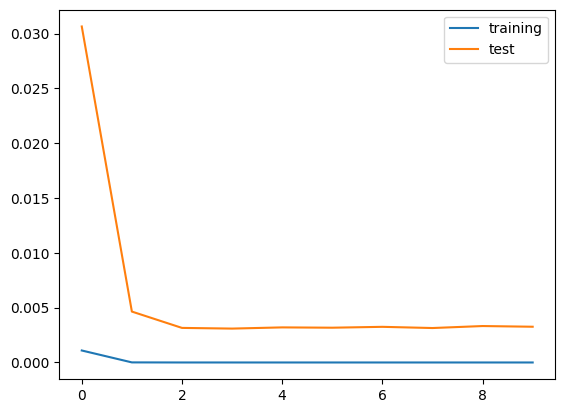

In [40]:
import matplotlib.pyplot as plt

plt.plot(list_training_loss, label='training')
plt.plot(list_test_loss, label='test')
plt.legend()
plt.show()